# This notebook is a Johdanto datatieteeseen 2022 project. 

Information on implementation and other parts of this course's assignments can be found on document. 'instructions.txt'

## Collecting data

In this project, I'm going to use data from Finnish car dealing website Autotalli.com. With this data, I'm going to create a ML model to predict the sales price for particular car. With this in mind, consumer or car dealer can check the valid price for a car. This is particularly interesting, because due to the component crisis, car markets are not saturated. The demand for cars is higher than supply, and therefore the prices have gone up. Before there used to be around 100k cars on sale in nettiauto.com, but nowadays there are about 80k sales notes. I first tried to scrape information from there, but the page loaded a dummy website because it recognised scraping.

In [3]:
#Import needed libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests as rq
import math


In [61]:
#Scrape data from Autotalli.com
baseUrl = "https://www.autotalli.com/vaihtoautot/listaa/sivu/"

#Dataset for scraped data. This dataset is saved into .csv file as a backup, so no need to scrape multiple times if an error with later coding is occurred.
raw_data = {
    'Make': [],
    'Model': [],
    'Year': [],
    'Odometer': [],
    'Sales price': []
}

In [67]:
#BS object
autotalli_page = rq.get(baseUrl)
soup = bs(autotalli_page.content, 'html.parser')
#There are 20 cars displayed in each page, so number of pages is number of cars/cars per page, rounded up.
intMaxPages = math.ceil(int(soup.find('span', class_="yhteensa").text)/100)

#Loop through all pages
for page in range(2,intMaxPages):
    #BS object
    url = baseUrl + str(page) + "/max_osumia/100"
    autotalli_page = rq.get(url)
    soup = bs(autotalli_page.content, 'html.parser')
    salesNotes = soup.find_all("div", class_="carsListItemDetailsContainer")

    #Loop through all notes in one page
    for note in salesNotes:
        details = note.find(class_="carsListItemCarNameContainer").find(class_="carsListItemNameLink").text
        #Take car make and model out of details
        details_splitted = details.split()

        make = details_splitted[0]
        model = details_splitted[1]
        
        year = note.find(class_="usedCarsListItemCarModelYear").find(class_="carsListItemCarBottomContainerItem").text
        price = note.find(class_="carsListItemCarPrice").find(class_="carsListItemCarBottomContainerItem").text
        odo = note.find(class_="usedCarsListItemCarMeterReading").find(class_="carsListItemCarBottomContainerItem").text

        #Add data to vector
        raw_data['Make'].append(make)
        raw_data['Model'].append(model)
        raw_data['Year'].append(year)
        raw_data['Odometer'].append(odo)
        raw_data['Sales price'].append(price)
        
        
#Write vector to pd dataframe        
dfRaw = pd.DataFrame(raw_data)
dfRaw.drop_duplicates(inplace=True)
print("Data scraped with total of", len(dfRaw), "rows")

Data scraped with total of 48442 rows


In [69]:
#Write the data to .csv file
dfRaw.to_csv("raw_data.csv")

## Data processing

The data itself is in pretty nice format, because the scraper was implemented for this website only.

In [33]:
#Load the csv file to Pandas dataframe and see what've got
data = pd.read_csv('raw_data.csv')

#Some basic information about the data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48442 entries, 0 to 48441
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   48442 non-null  int64 
 1   Make         48442 non-null  object
 2   Model        48442 non-null  object
 3   Year         48442 non-null  int64 
 4   Odometer     48442 non-null  int64 
 5   Sales price  48442 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


Unnamed: 0     Make   Model  Year  Odometer  Sales price
0           0     Opel  Vectra  2004    307000         1900
1           1     Ford   Focus  2003    262000         1900
2           2  Citroën      C5  2004    209000         1900
3           3      Kia   cee'd  2008    232000         1900
4           4  Hyundai    Getz  2005    200000         1900

The data seems like very clean. Let's remove the "Unnamed" column and search for irregularities in different columns.

In [34]:
data.drop(columns = ['Unnamed: 0'], inplace = True)
data.head()

Make   Model  Year  Odometer  Sales price
0     Opel  Vectra  2004    307000         1900
1     Ford   Focus  2003    262000         1900
2  Citroën      C5  2004    209000         1900
3      Kia   cee'd  2008    232000         1900
4  Hyundai    Getz  2005    200000         1900

In [35]:
print(data['Make'].unique())

['Opel' 'Ford' 'Citroën' 'Kia' 'Hyundai' 'Mazda' 'Volkswagen' 'Renault'
 'Peugeot' 'Nissan' 'Skoda' 'Chrysler' 'Fiat' 'Toyota' 'Volvo' 'Honda'
 'Mercedes-Benz' 'Chevrolet' 'Saab' 'Alfa' 'Subaru' 'Mitsubishi' 'Audi'
 'Daewoo' 'Smart' 'Jaguar' 'Dodge' 'BMW' 'Suzuki' 'SEAT' 'Mini' 'Rover'
 'Lexus' 'Jeep' 'Iveco' 'Dacia' 'Land' 'Cadillac' 'Pontiac' 'Morris'
 'Lada' 'MG' 'SsangYong' 'Porsche' 'Infiniti' 'Isuzu' 'Abarth' 'Lincoln'
 'Lancia' 'Plymouth' 'Fiat-Abarth' 'GMC' 'Buick' 'Hummer' 'Maserati'
 'Moskvitsh' 'DS' 'Lotus' 'Daimler' 'Tesla' 'Cupra' 'Maxus' 'TruckMasters'
 'Bentley' 'Datsun' 'Polestar' 'Ferrari' 'Mclaren']


In [36]:
print(data['Model'].unique())

['Vectra' 'Focus' 'C5' "cee'd" 'Getz' '626' 'Passat' 'Laguna' '206' 'Golf'
 '407' '6' 'Primera' 'Octavia' 'Bora' 'Vento' 'Sebring' 'Bravo' 'Avensis'
 'Carnival' 'V70' 'Meriva' 'Auris' 'Kangoo' 'Civic' 'E' 'Magentis' 'Astra'
 'Xsara' 'Punto' 'Clio' 'Yaris' 'Mondeo' 'Fiesta' 'Maxima' 'S40' 'C3'
 'Almera' 'C4' 'Tiida' 'Corsa' 'Expert' 'Mégane' '3' 'Kalos' 'Zafira'
 'S60' '9-3' 'S80' 'Trajet' 'C' 'Touran' '307' 'Panda' 'Romeo' 'Fabia'
 'Polo' '240' 'Boxer' 'Outback' 'Cerato' 'Grandis' 'A6' 'Scénic' 'Corolla'
 'Evanda' 'Nubira' '9-5' 'Pt' '406' 'Epica' 'Vito' '323' 'CR-V' 'Voyager'
 'A4' 'Micra' 'Transporter' 'ML' 'Forfour' 'C8' 'Grande' 'Accord' 'Camry'
 'X-Type' 'A' 'Avenger' 'Roomster' 'New' 'Verso' 'V50' 'NOTE' 'Orion'
 'S70' 'Colt' 'Ka' 'Kadett' 'H1' '607' 'Hiace' '530' 'Liana' 'L-200'
 'Aveo' '207' 'Santa' '308' 'Impreza' 'S-MAX' 'Grand' 'Carina' 'TT'
 'Altea' 'Accent' 'C-MAX' 'i30' 'Superb' 'Jazz' 'Previa' 'Fusion' 'Alto'
 'Stream' 'Caddy' 'Scudo' 'Caliber' 'Baleno' '960' 'Twingo' 'V

In [37]:
print(data['Odometer'].unique())


[307000 262000 209000 ...  59800  12704   4100]


Here we can see that there are actually rows with odometer value 0 or something very low. In this model, we want to get information about used cars. Let's decide that used cars have been driven for over 1000 km. 

In [38]:
#Drop all rows where car has been driven under 5000 km
for index, row in data.iterrows():
    if row['Odometer'] < 5000:
        data.drop(index, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45037 entries, 0 to 48441
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Make         45037 non-null  object
 1   Model        45037 non-null  object
 2   Year         45037 non-null  int64 
 3   Odometer     45037 non-null  int64 
 4   Sales price  45037 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


In [39]:
print(data['Sales price'].unique())

[  1900   1940   1950 ... 257900 258458 259800]


This website also includes leasing deals to be displayed in searches. Let's remove all of them by removing all rows where sales price is under 1000. This will most likely to take out the cars unsuitable for road conditions also.

In [40]:
#Drop all rows where Sales price in under 1000 euros
for index, row in data.iterrows():
    if row['Sales price'] < 1000:
        data.drop(index, inplace = True)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45037 entries, 0 to 48441
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Make         45037 non-null  object
 1   Model        45037 non-null  object
 2   Year         45037 non-null  int64 
 3   Odometer     45037 non-null  int64 
 4   Sales price  45037 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


Data is now cleaned so it can be saved to a new csv file. This data is used for training the ML model.

In [42]:
data.to_csv('train_data.csv', columns = ['Make', 'Model', 'Year', 'Odometer'])

## Describing data

The data 'train_data.csv' is imported as a Azure Dataset, and after that connected to Power BI. Seems like Azure ML Notebook doesn't yet support ipywidgets, so embedding PowerBI report via powerbiclient API gives no output. Code is still shown below and report can be accessed from:  [PowerBI Dashboard](https://app.powerbi.com/view?r=eyJrIjoiODk2M2IzZWYtOWJmZi00MmVmLWEzZGMtOWZkMzhhODVkYTZlIiwidCI6ImZhNjk0NGFmLWNjN2MtNGNkOC05MTU0LWMwMTEzMjc5ODkxMCIsImMiOjl9&pageName=ReportSection)

In [11]:
from powerbiclient import Report, models
embedUrl =  'https://app.powerbi.com/view?r=eyJrIjoiODk2M2IzZWYtOWJmZi00MmVmLWEzZGMtOWZkMzhhODVkYTZlIiwidCI6ImZhNjk0NGFmLWNjN2MtNGNkOC05MTU0LWMwMTEzMjc5ODkxMCIsImMiOjl9&pageName=ReportSection'

In [12]:
report = Report(embed_url = embedUrl, token_type=models.TokenType.EMBED.value)

Performing interactive authentication. Please follow the instructions on the terminal.
 To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code DU9F2BJSS to authenticate.
You have logged in.
Interactive authentication successfully completed.


In [14]:
report


Report()

Scatter matrix couldn't be displayed in PowerBI, so it's calculated locally here

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39f616f2e0>,
      dtype=object)

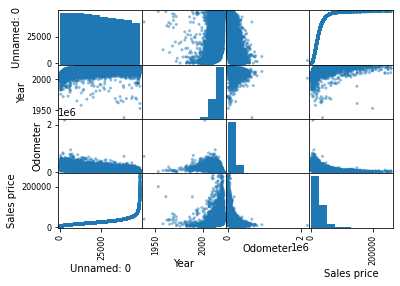

In [22]:
import pandas as pd
dataset = pd.read_csv('train_data.csv')
pd.plotting.scatter_matrix(dataset)

No obvious problems seems to be occurring in the dataset, so we can move to ML modeling.

## Machine learning model

The machine learning steps in this project is done in Azure ML with Automated ML. The 'training_data.csv' have been exported to a dataset in Azure ML storage, and therefore can be used with powerful ML tools. I choose the multi-regression model to predict car sales price based on the different parameters. 15% of the dataset was offered as a test data. Normalized root mean square error in model was 0,028, explained variance 0,88, Spearman correlation 0,94 and normalized mean absolute error 0,016. The picture below shows the weighted importance of different factors in sales price. Car make and year seems to be the most important factors. With these in mind, we can assume that the model gives pretty good predictions for average-year cars. But if the car is very old or have been driven many kilometers, the model is likely to give a polarized price prediction. Below you can also find the average car data characteristics in training data.

!['Top 4 ML_model_features'](/ML_model_features.png)!['Key characteristics'](/train_data_key_characteristics.png)

[]()

## User implementation

After the ML model is created, it can be implemented for web use in Azure ML environment. Here below is code generated from endpoint deployment, which is then fitted to a callable function for easy access. The function priceRequestQuota() performs a request to Azure ML endpoint, and calculates the predicted sales price based on user's input and ML model-

In [9]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

def priceRequestQuota(Make, Model, Year, Odometer):
# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
    data = {
    "Inputs": {
        "data": [
            {
            "Column2": "example_value",
            "Make": Make,
            "Model": Model,
            "Year": Year,
            "Odometer": Odometer
            }
        ]
    },
    "GlobalParameters": {
    }
}

    body = str.encode(json.dumps(data))

    url = 'http://2b7c02b7-0d3c-4535-bd4e-77a39b79a272.northeurope.azurecontainer.io/score'
    api_key = 'zEZH4P4Vv5uLXaPgavBMdaQ6vNdjYrxi' # Replace this with the API key for the web service
    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

    req = urllib.request.Request(url, body, headers)

    try:
        response = urllib.request.urlopen(req)

        result = response.read()

        #Decode byte to string
        decoded = result.decode()

        #Find price inside the tags
        price = round(float(decoded[decoded.find("[")+1:decoded.find("]")]))
    
        #Print market price
        print("The predicted price for", Make, Model, "vm.", Year, Odometer, "km")
        
        print("is", price, " euros.")
    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))

        # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))

When running the following code, user is asked for input about the details of car. Please fill out the details below for a quote request. The predicted price is based on Automated ML model generated in Azure ML. 

In [16]:
Make = input("Make")
Model = input("Model")
try:
    Year = int(input("Year"))
    Odometer = int(input("Odometer"))

    #Call function to request quota from ML model
    priceRequestQuota(Make, Model, Year, Odometer)
except:
    print("Year and Odometer must be integers")


The predicted price for Volkswagen Golf vm. 2019 200000 km
is 20062  euros.
